In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import traja

In [2]:
data = np.load('newrawdata.npy',allow_pickle=True)
flynum = data[1].shape[0] #384

In [3]:
food_type = data[1]
starve_period = data[2]
meal_vol = data[15]
xcm = data[3] #x center of mass location #(384,)
ycm = data[5]
start_time = data[12]
t_offset = 1.0/3.0 
t = data[16] - t_offset

### Get x,y 5 seconds AFTER 1st meal

In [4]:
# ? seconds before 1st meal -> 1st meal
first_meal_start = np.array([start_time[i][0] for i in range(flynum)])

# get that trajectory
x_traj = []
y_traj = []
for i in range(flynum):
    idx = (t[i] >= (first_meal_start[i])) & (t[i] <= (first_meal_start[i] + 5))   #5 seconds after 1st meal
    x_traj.append(xcm[i][idx])
    y_traj.append(ycm[i][idx])
x_traj = np.array(x_traj,dtype=object)
y_traj = np.array(y_traj,dtype=object)

def traj(flyno):
    return np.vstack((x_traj[flyno], y_traj[flyno]))

### Finding Conditions

In [5]:
#By Foodtype
mM1000 = np.where(food_type == '1000mM')[0] #(90,)
mM100 = np.where(food_type == '100mM')[0]
mM10 = np.where(food_type == '10mM')[0]
mM1 = np.where(food_type == '1mM')[0]  #(48,)
mMwater = np.where(food_type == 'water')[0]

#By starvetime
st_0 = np.where(starve_period == '0')[0]
st_8 = np.where(starve_period == '8')[0]
st_16 = np.where(starve_period == '16')[0]
st_24 = np.where(starve_period == '24')[0]
st_32 = np.where(starve_period == '32')[0]

#Volume of first bout 
vol_first = np.array([meal_vol[i][0] for i in range(flynum)])

### Multiple Trajectories

In [6]:
from traja import TrajaCollection

def create_df(flyno):
    x_fly = traj(flyno)[0]
    y_fly = traj(flyno)[1]
    d = {'x': x_fly, 'y': y_fly}
    df = pd.DataFrame(data=d)
    df = traja.TrajaDataFrame(df)
    return df

# Create a dictionary of DataFrames, with 'id' as key.
keys = np.arange(flynum)
all_values = [] #create values - i.e. df for each fly
for n in range(flynum):
    all_values.append(create_df(n))

df_all = {}
for i in range(flynum):
    df_all[i] = all_values[i]

# Create a TrajaCollection df (x,y,id)
trjs = TrajaCollection(df_all)

## 1. Calculating Turning Points for each fly (grouped)

In [7]:
def all_angles_wrt_xaxis(condition):
    '''angle between steps as a function of displacement with regard to x axis.
    "e.g. condition = st_0"'''
    all_turns = []
    for j in range(len(condition)):
        turns = traja.calc_angle(trjs[trjs['id'] == condition[j]])
        if turns.shape == (150,):
            all_turns.append(turns)
    return  np.array(all_turns)

In [8]:
def turning_point(min_angle, condition):
    all_turns = all_angles_wrt_xaxis(condition)
    theta = np.abs(np.diff(all_turns, axis=1)) #diff in angle
    idx_all = []
    for i in range(len(condition)-1):
        idx = np.where([theta[i] > min_angle][0])[0]
        idx_all.append(idx)
    return np.array(idx_all, dtype = list)

In [9]:
def plot_turn_points(fly_num, min_angle, condition):
    turn_pt = turning_point(min_angle, condition)
    sx = trjs[trjs['id'] == st_0[fly_num]]['x']
    sy = trjs[trjs['id'] == st_0[fly_num]]['y']
    idx = turn_pt[fly_num]  
    # Visualize valuable turning points
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(sx, sy, 'k--', label='trajectory')
    ax.plot(sx[idx], sy[idx], 'ro', markersize = 4, label='turning points')
    ax.set_xlabel("cm")
    ax.set_ylabel("cm")
    ax.legend(loc='best')
    ax.set_title('Trajectory of Example Fly')

### You are free to change these variables

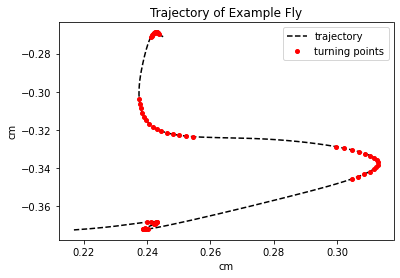

In [10]:
min_angle = 2
condition = st_0 #0-hr fasted
fly_num = 7
plot_turn_points(fly_num, min_angle, condition)

## 2. Calculating Straightness (path / D) for each fly (grouped)

In [11]:
import math
def calculate_distance(starting_x, starting_y, destination_x, destination_y):
    distance = math.hypot(destination_x - starting_x, destination_y - starting_y)  # calculates Euclidean distance (straight-line) distance between two points
    return np.abs(distance)

def calculate_path(selected_map):
    total_distance = 0
    current_point = selected_map[0]
    for next_point in selected_map[1:]:
        current_distance = calculate_distance(
            current_point[0], current_point[1],
            next_point[0], next_point[1])
        total_distance += current_distance
        current_point = next_point
    return total_distance

In [12]:
def all_straightness(cond):
    "cond = st_0"
    str_all = []
    for i in range(len(cond)):
        flytraj = traj(i)
        x, y = flytraj 
        d = calculate_distance(x[0], y[0], x[-1], y[-1])
        path = calculate_path(flytraj.T)
        straightness = path/d
        str_all.append(straightness)
    return np.array(str_all)

In [13]:
print('Straightness(0-hr starved):'+ str(all_straightness(st_0)))

Straightness(0-hr starved):[1.285619   1.00005956 1.3902732  2.70332534 1.00016323 1.00004434
 1.05024074 2.35158293 1.00072111 1.81235882]


## 3. Calculating Thoroughness for each fly (grouped)

In [14]:
def Length(flyno):
    flytraj = traj(flyno)
    lengths = np.sqrt(np.sum(np.diff(flytraj, axis=0)**2, axis=1)) # Total length: L
    return np.sum(lengths)  

In [15]:
def radius(flyno):
    flytraj = traj(flyno)    
    from scipy import spatial
    cand = flytraj[spatial.ConvexHull(flytraj).vertices]
    dist_mat = spatial.distance_matrix(cand, cand)
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
    #print(cand[i], cand[j])
    import math
    dist = math.hypot(cand[j][0] - cand[i][0], cand[j][1] - cand[i][1])
    r = dist/2
    return r

In [16]:
w = 1/10 #assume width of flies' body = 1mm

def thoroughnessind(L,r,w = 1/10):
    return 1- np.exp(((-4)*L*w)/(np.pi* (r**2)))    #find out why is it 4

def all_t(cond):
    "cond = st_0"
    t_all = []
    for n in cond:
        L = Length(n)
        r = radius(n)
        t = thoroughnessind(L,r,w = 1/10)
        #print('fly: ' + str(n) + ' t: '+ str(t))
        t_all.append(t)
    return np.array(t_all)